In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/stats207

/content/drive/.shortcut-targets-by-id/1BB-W8du-illju1EqYOHrL-R-3_okYgze/stats207


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

#Data Pre-Processing

In [ ]:
aqi_weekly = pd.read_csv("aqi_weekly_cleaned.csv")
aqi_weekly.head()

,week,aqi,co,ozone,pm25,no2
0,2012-01-01,75.000000,16.428571,18.857143,75.000000,36.571429
1,2012-01-08,81.714286,17.714286,20.428571,81.714286,44.571429
2,2012-01-15,48.714286,11.428571,28.714286,48.142857,31.857143
3,2012-01-22,40.857143,7.714286,23.714286,39.428571,26.428571
4,2012-01-29,55.285714,8.857143,23.857143,55.285714,33.142857


In [ ]:
#Split Data
train = aqi_weekly.iloc[:418, 1:].values
test = aqi_weekly.iloc[418:, 1:].values

print(train.shape)
print(test.shape)

(418, 5)
(104, 5)


In [ ]:
#Scale Data
scaler = StandardScaler()

train1 = scaler.fit_transform(train)
test1 = scaler.fit_transform(test)

print(train1[:5])
print(test1[:5])

[[ 1.94961646  2.45552678 -1.60596094  2.22861216  1.50340785]
 [ 2.43446627  2.84184711 -1.47059755  2.67280617  2.48223495]
 [ 0.05148105  0.95316994 -0.7568633   0.45183615  0.92659902]
 [-0.51589638 -0.16286657 -1.187565   -0.12467096  0.26239491]
 [ 0.5260149   0.18052928 -1.17525924  0.92438296  1.08391052]]
[[-0.85049806  0.39363583 -1.09536014 -0.53317964  0.99957096]
 [-0.85049806  0.17427548 -0.91450119 -0.57965102  0.99957096]
 [ 0.11046114  1.0517169  -1.28913758  0.29555996  0.86622563]
 [-0.31101219  0.72267637 -1.17287112 -0.06846585  0.80907764]
 [-0.34473006  0.72267637 -0.74656073 -0.24660614  1.11386695]]


In [ ]:
#Lag Vars params
timesteps = 10
n_cols = 5

In [ ]:
#create seqs function
def create_sequences(data, timesteps, n_cols):
  data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
  n_obs = data_timesteps.shape[0]
  data_timesteps = data_timesteps.reshape(n_obs, (timesteps+1)*n_cols)
  x, y = data_timesteps[:,:-n_cols], data_timesteps[:,[-n_cols]]

  return x, y 

In [ ]:
#create lag var seqs
x_train, y_train = create_sequences(train1, timesteps, n_cols)
x_test, y_test = create_sequences(test1, timesteps, n_cols)

print(train1[0:6])
print(x_train[0], y_train[0])

[[ 1.94961646  2.45552678 -1.60596094  2.22861216  1.50340785]
 [ 2.43446627  2.84184711 -1.47059755  2.67280617  2.48223495]
 [ 0.05148105  0.95316994 -0.7568633   0.45183615  0.92659902]
 [-0.51589638 -0.16286657 -1.187565   -0.12467096  0.26239491]
 [ 0.5260149   0.18052928 -1.17525924  0.92438296  1.08391052]
 [ 0.26811607  0.26637824 -0.71994601  0.60305113  1.04895241]]
[ 1.94961646  2.45552678 -1.60596094  2.22861216  1.50340785  2.43446627
  2.84184711 -1.47059755  2.67280617  2.48223495  0.05148105  0.95316994
 -0.7568633   0.45183615  0.92659902 -0.51589638 -0.16286657 -1.187565
 -0.12467096  0.26239491  0.5260149   0.18052928 -1.17525924  0.92438296
  1.08391052  0.26811607  0.26637824 -0.71994601  0.60305113  1.04895241
 -0.75316331 -0.46333794 -0.7568633  -0.41764999  0.12256247 -0.34052518
 -0.20579105 -0.69533448  0.10215151  0.41970641 -0.60873996 -0.42041346
 -0.28924431 -0.31368969  0.64693413 -0.30957732 -0.37748898 -0.20310397
 -0.07741628  0.73432941] [-0.96979833]

# XGBoost

In [ ]:
param_grid = {
    'min_child_weight': [2, 4, 8],
    'gamma': [1, 5, 10, 50],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.5, 0.1, 0.01],
    'objective': ['reg:squarederror']
}

# 'subsample': [0.8],
#     'colsample_bytree': [0.8],
#    'n_estimators': [100],

grid = GridSearchCV(XGBRegressor(), param_grid, refit = False, verbose=True)

In [ ]:
grid.fit(x_train, y_train[:,0])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=XGBRegressor(),
             param_grid={'gamma': [1, 5, 10, 50],
                         'learning_rate': [0.5, 0.1, 0.01],
                         'max_depth': [3, 4, 5], 'min_child_weight': [2, 4, 8],
                         'objective': ['reg:squarederror']},
             refit=False, verbose=True)

In [ ]:
print(grid.best_params_)

{'gamma': 10, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'objective': 'reg:squarederror'}


In [ ]:
model = XGBRegressor(max_depth = grid.best_params_['max_depth'], 
                     learning_rate=grid.best_params_['learning_rate'], 
                     objective = 'reg:squarederror', 
                     nthread = 4,
                     gamma = grid.best_params_['gamma'],
                     min_child_weight= grid.best_params_['min_child_weight'],
                     subsample = 0.8, colsample_bytree= 0.8
                     )
model.fit(x_train, y_train[:,0])

XGBRegressor(colsample_bytree=0.8, gamma=10, min_child_weight=4, nthread=4,
             objective='reg:squarederror', subsample=0.8)

# Evaluation

In [ ]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(408, 1) (94, 1)


In [ ]:
# Scaling back the predictions
# some hacks to make inverse_transform work 
# create empty table with n_cols fields
train_like = np.zeros(shape=(len(y_train_pred), n_cols) )
# put the predicted values in the right field
train_like[:,0] = y_train_pred[:,0]
# inverse transform and then select the right field
y_train_pred = scaler.inverse_transform(train_like)[:,0]

In [ ]:
test_like = np.zeros(shape=(len(y_test_pred), n_cols) )
test_like[:,0] = y_test_pred[:,0]
y_test_pred = scaler.inverse_transform(test_like)[:,0]

In [ ]:
print(len(y_train_pred), len(y_test_pred))

411 97


In [ ]:
# Scaling the original values
train_like = np.zeros(shape=(len(y_train), n_cols) )
train_like[:,0] = y_train[:,0]
y_train = scaler.inverse_transform(train_like)[:,0]

In [ ]:
test_like = np.zeros(shape=(len(y_test), n_cols) )
test_like[:,0] = y_test[:,0]
y_test = scaler.inverse_transform(test_like)[:,0]

In [ ]:
print(y_train_pred[:10])
print(y_test_pred[:10])

[48.40674958 49.40580522 48.64597014 45.55336812 48.23402861 45.06145473
 47.55114505 44.67442126 44.35404193 47.15080196]
[48.30159997 47.12681111 46.80643178 57.61411702 55.00512754 44.67442126
 44.35404193 44.6984121  44.6984121  44.6984121 ]


In [ ]:
mae = metrics.mean_absolute_error(y_test_pred, y_test)
mape = metrics.mean_absolute_percentage_error(y_test_pred, y_test)
mse = metrics.mean_squared_error(y_test_pred, y_test)
rmse = np.sqrt(mse)

print("MAE: ", mae)
print("MAPE: ", mape)
print("MSE: ", mse)
print("RMSE: ", rmse)

MAE:  10.262783972584652
MAPE:  0.19621432978550515
MSE:  252.77137232923343
RMSE:  15.89878524696882



# Plotting


In [ ]:
train_timestamps = aqi_weekly.iloc[timesteps:418,0]
test_timestamps = aqi_weekly.iloc[418+timesteps:,0]

print(len(train_timestamps), len(test_timestamps))

413 99


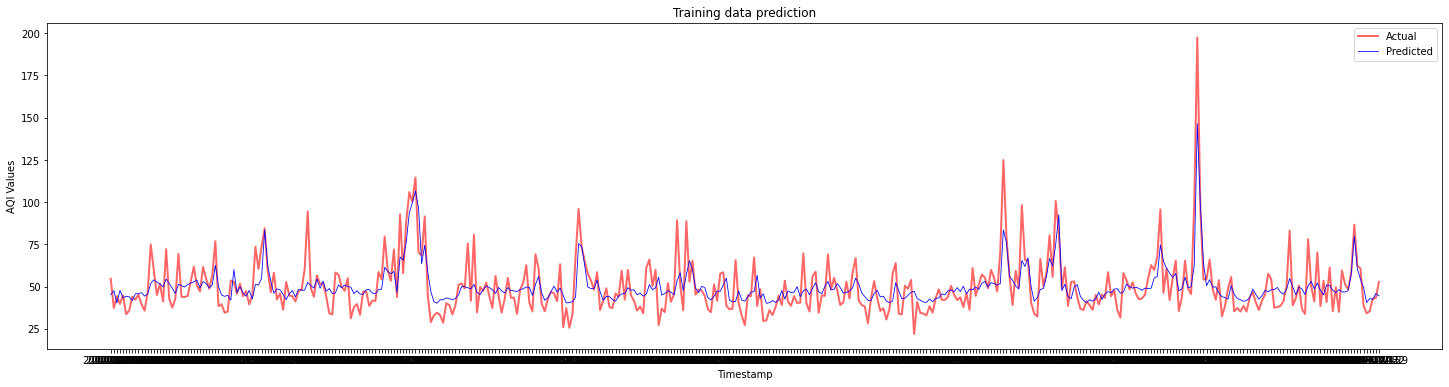

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.ylabel('AQI Values')
plt.title("Training data prediction")
plt.show()

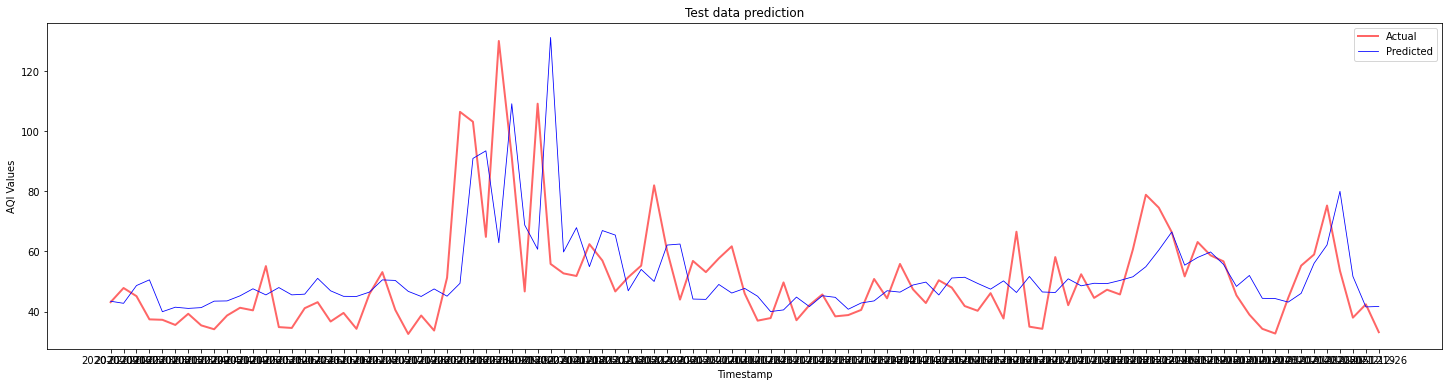

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
#plt.legend()
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.ylabel('AQI Values')
plt.title("Test data prediction")
plt.show()

NameError: ignored

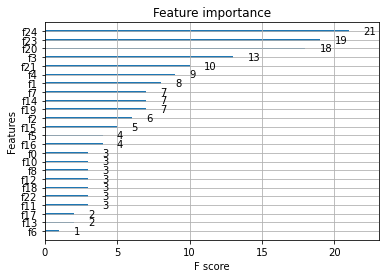

In [ ]:
# plot feature importance
plot_importance(model)
pplt.show()